In [3]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML, Image
from scipy.stats import ttest_ind_from_stats, spearmanr
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter 
import tqdm
import math
import xarray as xr
from scipy.special import softmax
import torch
%matplotlib inline
from torch.autograd import Variable


In [4]:
if torch.__version__ != '1.10.0':
    print('You need to upgrade PyTorch before running this code.')

else:
    print('Ready to go!')

Ready to go!


# Model definition 

In [72]:
class BinaryTS:
    
    def __init__(self,d=10, A=None, B=None, sigma=None,R=10000):
        
        """
        Instanciates the binaryTS model. 
        
        Arguments: 
        
        - d: dimension of the model. 
        - A: (d,d) matrix that controls the dynamics related to the observed state. 
        - B: (d,d) matrix that controls the dynamics related to the latent state. 
        - sigma: (d,d) positive definite matrix that controls the variance of the noise. 
        - R: number of MCMC samples for expectation approximations used in VEM. 
        
        By default, the BinaryTS model is instanciated with random matrices A, B and sigma. You can provide your 
        own, but B should have all its eigenvalues of module less than 1 in order to enforce stability of the model
        (see companion paper for further information). 
        
        """
        
        self.d = d
        
        if A is None:
            #self.true_A = np.identity(d) + 0.1*np.random.randn(d,d)
            self.true_A = np.zeros((d,d))
        else: 
            self.true_A = A
            
        if B is None:     
            random_eig = np.random.uniform(low=-0.7,high=0.7,size=d) 
            self.true_B = np.diag(random_eig) 
        else:
            self.true_B = B

        self.eig_B = np.abs((np.linalg.eig(self.true_B)[0]))
        
        random_matrix = np.random.randn(d,d)
        self.true_sigma = 1/5*np.dot(random_matrix,random_matrix.T)
        self.true_sigma_inv = np.linalg.inv(self.true_sigma)
        self.data = None
        self.R = 10000
        
        
    ### Util functions###
    
    def sample(self,N=100,T=100,fixdata=True):
        
        """
        Samples N samles over T timesteps from the DGP. If fixdata is set to True, sampled x data is saved in 
        an attribute called self.data, along with (N,T) used for sampling in self.N and self.T. 
        """
        
        x_data = np.zeros((N,self.d,T+1))
        z_data = np.zeros((N,self.d,T+1))
        p_data = np.zeros((N,self.d,T+1))
        
        self.x0 = np.random.randint(0,2,size=(self.d,N))
        self.z0 = np.random.randn(self.d,N)
        
        x = self.x0
        z = self.z0
        
        x_data[:,:,0] = self.x0.T
        z_data[:,:,0] = self.z0.T
        p_data[:,:,0] = 1/2*np.ones((N,self.d))
        
        for t in np.arange(1,T+1): 
            z = self.true_A@x + self.true_B@z + np.random.multivariate_normal(mean=np.zeros(self.d),cov=self.true_sigma,size=N).T
            p = 1/(np.exp(z)+1)
            x = np.random.binomial(1,p,size=(self.d,N))
            x_data[:,:,t] = x.T
            z_data[:,:,t] = z.T
            p_data[:,:,t] = p.T
            
        if fixdata: 
            self.data = x_data
            self.N = N
            self.T = T
        
        return x_data,z_data,p_data
    
    def snapshot(self,N,T,x_data=None,z_data=None,p_data=None,pltdim = 3,plttime=500,save=False): 
        
        """
        Generates and plots some data from the data generating process. This method displayes three components 
        of the DGP for every dimension: 
        - the observed, 0-1 valued process
        - the latent state
        - the probability associated to the current latent state obtained through softmaxification. 
        
        Arguments:
        
        - N: number of individuals (for plotting, one is choosen at random).
        - T: number of timesteps over which data is generated. 
        - x_data, z_data, p_data: allows to pass previously generate data for plotting (instead of 
        generating new observations).
        - pltdim: number of dimensions plotted. 
        - plttime: number of timesteps plotted. 
        - save: if set to True, a .pdf of the generated image is saved. 
        """
        
        if x_data is None and z_data is None and p_data is None: 
            x_data,z_data,p_data = self.sample(N=N,T=T,fixdata=False)
            
        plttime = np.minimum(T,plttime)
        pltdim = np.minimum(pltdim,self.d)
        random_ind = np.random.randint(0,N)
        
        sns.set_context('talk')
        sns.set_style('white')
            
        f,ax=plt.subplots(pltdim,3,figsize=(pltdim*25,pltdim*10))
        
        for i in np.arange(pltdim):
        
            ax[i,0].plot(x_data[random_ind,i,:plttime],c='orange')
            ax[i,1].plot(z_data[random_ind,i,:plttime],c='red')
            ax[i,2].plot(p_data[random_ind,i,:plttime],c='green')
                        
            ax[i,0].set_yticks([0,1])
            
            for a in ['left','bottom']:
            
                ax[i,0].spines[a].set_linewidth(2.5)
                ax[i,1].spines[a].set_linewidth(2.5)
                ax[i,2].spines[a].set_linewidth(2.5)
            
            for j in [0,1,2]:
                ax[i,j].spines["right"].set_visible(False)
                ax[i,j].spines["top"].set_visible(False)
        
        
        plt.tight_layout()
        
        if save: 
            
            plt.savefig('snapshot.pdf')
    
    
    ### Functions for VEM ###
    
    def variance_initialization(self): 
        
        return torch.rand(self.d,2*self.T+1)
    
    def form_B(self,nu_omega): 
        
        """
        Forms a tensor of Cholesky decompositions, starting from a vector of params. 
        """
        
        nu = nu_omega[:,:self.T+1]
        omega = nu_omega[:,self.T+1:]
        
        B=torch.diag_embed(nu)+torch.diag_embed(omega,offset=1)
        
        return B

    
    def compute_precision(self,B): 
        
        """
        Computes the precision matrix, starting from the Cholesky decomposition. 
        
        Arguments:
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.
        """
        
        return torch.transpose(B,dim0=1,dim1=2)@B
    
    def compute_covmat(self,B): 
        
        """
        Computes the variance-covariance matrix, starting from the Cholesky decomposition, in a differentiable way.
        
        Arguments: 
            - B: (d,T,T) tensor, where (i,:,:) is the Cholesky decomposition of the i-th precision matrix.   
        """
        
        return torch.linalg.inv(torch.transpose(B,dim0=1,dim1=2)@B)
    
    def check_data(self):
        
        if self.data is None: 
            raise ValueError('self.data is empty. Use self.sample(args,fixdata=True) to sample some data first.')
            
    def full_log_expectation(self): 
    
        """
        Approximates the expectation w.r.t. to the variational density of log sum_{all terms} exp in the ELBO term. 
        Returns a scalar. 

        """
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        A = self.A
        B = self.B
        sigma_inv = self.sigma_inv
        
        mu_approx = self.mu_approx
        var_approx = self.var_approx
        
        precision_matrix = self.compute_precision(self.form_B(var_approx))
        covariance_matrix = self.compute_covmat(precision_matrix)
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        print(diagonal_terms)
        draw = torch.randn(self.R,self.d,self.T+1)
        transformed_draw = diagonal_terms*draw + mu_approx
        exp_draw = torch.exp(-transformed_draw) + 1
        #print(exp_draw)
        log_exp_draw = torch.log(exp_draw)
        matrix_approx = log_exp_draw.mean(axis=0)        
        return matrix_approx
    
    def compute_bilinear_term(self):
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        A = self.A
        B = self.B
        sigma_inv = self.sigma_inv
        
        mu_approx = self.mu_approx
        var_approx = self.var_approx
        
        
        data = Variable(torch.from_numpy(self.data).type(torch.FloatTensor))
                        
        result = -N/2*torch.trace(mu_approx[:,1:].T@sigma_inv@mu_approx[:,1:])
        
        result += N*torch.trace(mu_approx[:,1:].T@sigma_inv@B@mu_approx[:,:T])
        
        result += -N/2*torch.trace(mu_approx[:,:T].T@(B.T)@sigma_inv@B@mu_approx[:,:T])
        
        result += -1/2*sum([torch.trace((A@data[i,:,:T]).T@sigma_inv@(A@data[i,:,:T])) for i in np.arange(N)])
                
        result += -sum([torch.trace((A@data[i,:,:T]).T@sigma_inv@(B@mu_approx[:,:T]-mu_approx[:,1:])) for i in np.arange(N)])
        
        return result   
        
    def compute_elbo(self):
        
        """
        Returns the Evidence Lower Bound (ELBO) of the model, normalized by 1/(N*T*d).  
        
        Arguments:
        - mu_approx: (d,T+1) tensor. Expectations of the variational density.   
        - var_approx: (d,T,T) tensor. Cholesky decomposition of the precision matrix. Reconstruction
        of the precision matrix is enabled by self.compute_precision(var_approx). 
        - B: (d,d) matrix for ELBO evaluation. If None, the true A matrix of the model is used.
        - sigma: (d,d) positive definite matrix for ELBO evaluation. 
        If None, the true A matrix of the model is used.
        
        """
        
        self.check_data()
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        A = self.A
        B = self.B
        sigma = self.sigma
        sigma_inv = torch.linalg.inv(sigma)
        mu_approx = self.mu_approx
        var_approx = self.var_approx
        
        
        
        data = Variable(torch.from_numpy(self.data).type(torch.FloatTensor))
        
        var_approx = self.form_B(var_approx)
        
        variational_entropy = 2*N*sum([sum(torch.log(torch.diag(var_approx[i,:,:]))) for i in np.arange(d)])

        entropy = -(T*N/2)*torch.logdet(sigma)
        
        #Compute bilinear term
        
        bilinear_term = self.compute_bilinear_term()
        
        #Compute big sum with approximated expectations
        
        mu_x_prod = sum([torch.trace((data[i,:,1:].T-1)@mu_approx[:,1:]) for i in np.arange(N)])
                                
        print(self.full_log_expectation().sum())
        
        big_sum = mu_x_prod + self.full_log_expectation().sum()
        
        #Compute trace term
        
        covariance_matrix = self.compute_covmat(var_approx)
        diagonal_terms = torch.diagonal(covariance_matrix,offset=0,dim1=1,dim2=2)
        sub_diagonal_terms = torch.diagonal(covariance_matrix,offset=1,dim1=1,dim2=2)
        
        trace_term = (torch.diagonal(sigma_inv)*(diagonal_terms[:,1:].sum(axis=1))).sum()
        
        trace_term += (torch.diagonal(B.T@sigma_inv@B)*(diagonal_terms[:,:T].sum(axis=1))).sum()
        
        trace_term += -(torch.diagonal(sigma_inv@B)*(sub_diagonal_terms.sum(axis=1))).sum()
        
        trace_term = 1/2*trace_term 
        
        #Put all terms together
        
        elbo_value = variational_entropy + entropy + bilinear_term + big_sum + trace_term 
        

        return (1/(N*T*d))*elbo_value
    
    
    
    def v_step(self,max_iter=500,lr=1e-5,verbose=True): 
        
        if self.mu_approx is None:
            data_mean = self.data.mean(axis=0)
            mu_approx = torch.from_numpy(data_mean)
            mu_approx = mu_approx.float()
            mu_approx.requires_grad=True
            self.mu_approx = mu_approx
            
        if self.var_approx is None:
            var_approx = self.variance_initialization()
            var_approx.requires_grad = True  
            self.var_approx = var_approx
        
        mu_approx = self.mu_approx
        var_approx = self.var_approx
        
        optimizer = torch.optim.Adam([self.mu_approx,self.var_approx], lr=lr)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            elbo = -self.compute_elbo()

            elbo.backward(retain_graph=True)
    
            optimizer.step()

            self.elbo_track = torch.cat((self.elbo_track,torch.tensor([-elbo])))
        
            if t%10 == 0 and verbose: 
                
                print('V-step ELBO:', elbo)
                
        self.mu_approx = mu_approx
        self.var_approx = var_approx

                
    def em_step(self,max_iter=500,lr=0.0075,verbose=True): 
        
        #torch.autograd.set_detect_anomaly(True)
        
        A = self.A
        B = self.B
        sigma = self.sigma
                
        optimizer = torch.optim.Adam([self.A,self.B,self.sigma], lr=lr)
        
        for t in range(max_iter):
            
            optimizer.zero_grad()

            elbo = - self.compute_elbo()

            elbo.backward(retain_graph=True)
    
            optimizer.step()
        
            self.elbo_track = torch.cat((self.elbo_track,torch.tensor([-elbo])))
            A_error = torch.tensor([torch.norm(torch.tensor(self.true_A)-self.A)])
            self.A_error_track = torch.cat((self.A_error_track,A_error))
            B_error = torch.tensor([torch.norm(torch.tensor(self.true_B)-self.B)])
            self.B_error_track = torch.cat((self.B_error_track,B_error))
            sigma_error = torch.tensor([torch.norm(torch.tensor(self.true_sigma)-self.sigma)])
            self.sigma_error_track = torch.cat((self.sigma_error_track,sigma_error))
                
            if t%10 == 0: 
                
                print('EM-step ELBO:', elbo)
                
        self.A = A
        self.B = B
        self.sigma = sigma
        

    def optimize(self,max_iter=100,lr=1e-10,verbose=True):
        
        T = self.T
        N = self.N
        d = self.d
        R = self.R
        
        it = 1
        
        #Parameters initialization
        
        sigma = torch.eye(d,d)
        sigma.requires_grad=True
        self.sigma = sigma
        self.sigma_inv = torch.linalg.inv(sigma)
        
        A = torch.eye(d,d) + torch.randn(d,d)
        A.requires_grad = True
        self.A = A
        
        B = torch.eye(d,d)
        B.requires_grad = True
        self.B = B
        
        data_mean = self.data.mean(axis=0)
        mu_approx = torch.from_numpy(data_mean)
        mu_approx = mu_approx.float()
        mu_approx.requires_grad=True
        self.mu_approx = mu_approx
        
        var_approx = self.variance_initialization()
        var_approx.requires_grad = True
        self.var_approx = var_approx
        
        #Saving training results
        
        self.elbo_track = torch.zeros(1)
        self.A_error_track = torch.zeros(1)
        self.B_error_track = torch.zeros(1)
        self.sigma_error_track = torch.zeros(1)
        
        for t in np.arange(max_iter):
            
            self.em_step(max_iter=10*it,verbose=verbose)
            self.v_step(max_iter=it,verbose=verbose)
            

# Optimization tests

In [73]:
bints = BinaryTS(d=2)

In [74]:

bints.sample(N=25,T=3)

(array([[[0., 0., 1., 1.],
         [0., 1., 0., 1.]],
 
        [[1., 1., 1., 0.],
         [1., 0., 0., 1.]],
 
        [[0., 1., 1., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 0., 0., 0.],
         [0., 1., 1., 1.]],
 
        [[1., 1., 1., 0.],
         [0., 0., 0., 1.]],
 
        [[0., 0., 0., 1.],
         [0., 1., 1., 1.]],
 
        [[0., 1., 1., 0.],
         [0., 0., 0., 0.]],
 
        [[0., 1., 1., 1.],
         [1., 1., 1., 1.]],
 
        [[1., 1., 0., 0.],
         [0., 1., 0., 1.]],
 
        [[0., 1., 1., 1.],
         [0., 0., 0., 0.]],
 
        [[0., 1., 1., 0.],
         [1., 1., 1., 1.]],
 
        [[0., 0., 1., 0.],
         [0., 1., 1., 0.]],
 
        [[1., 1., 1., 0.],
         [1., 0., 1., 0.]],
 
        [[0., 0., 0., 0.],
         [1., 0., 0., 0.]],
 
        [[0., 1., 1., 1.],
         [1., 1., 0., 1.]],
 
        [[1., 0., 1., 0.],
         [0., 0., 1., 1.]],
 
        [[1., 0., 0., 1.],
         [1., 1., 0., 0.]],
 
        [[1., 0., 1., 0.],
    

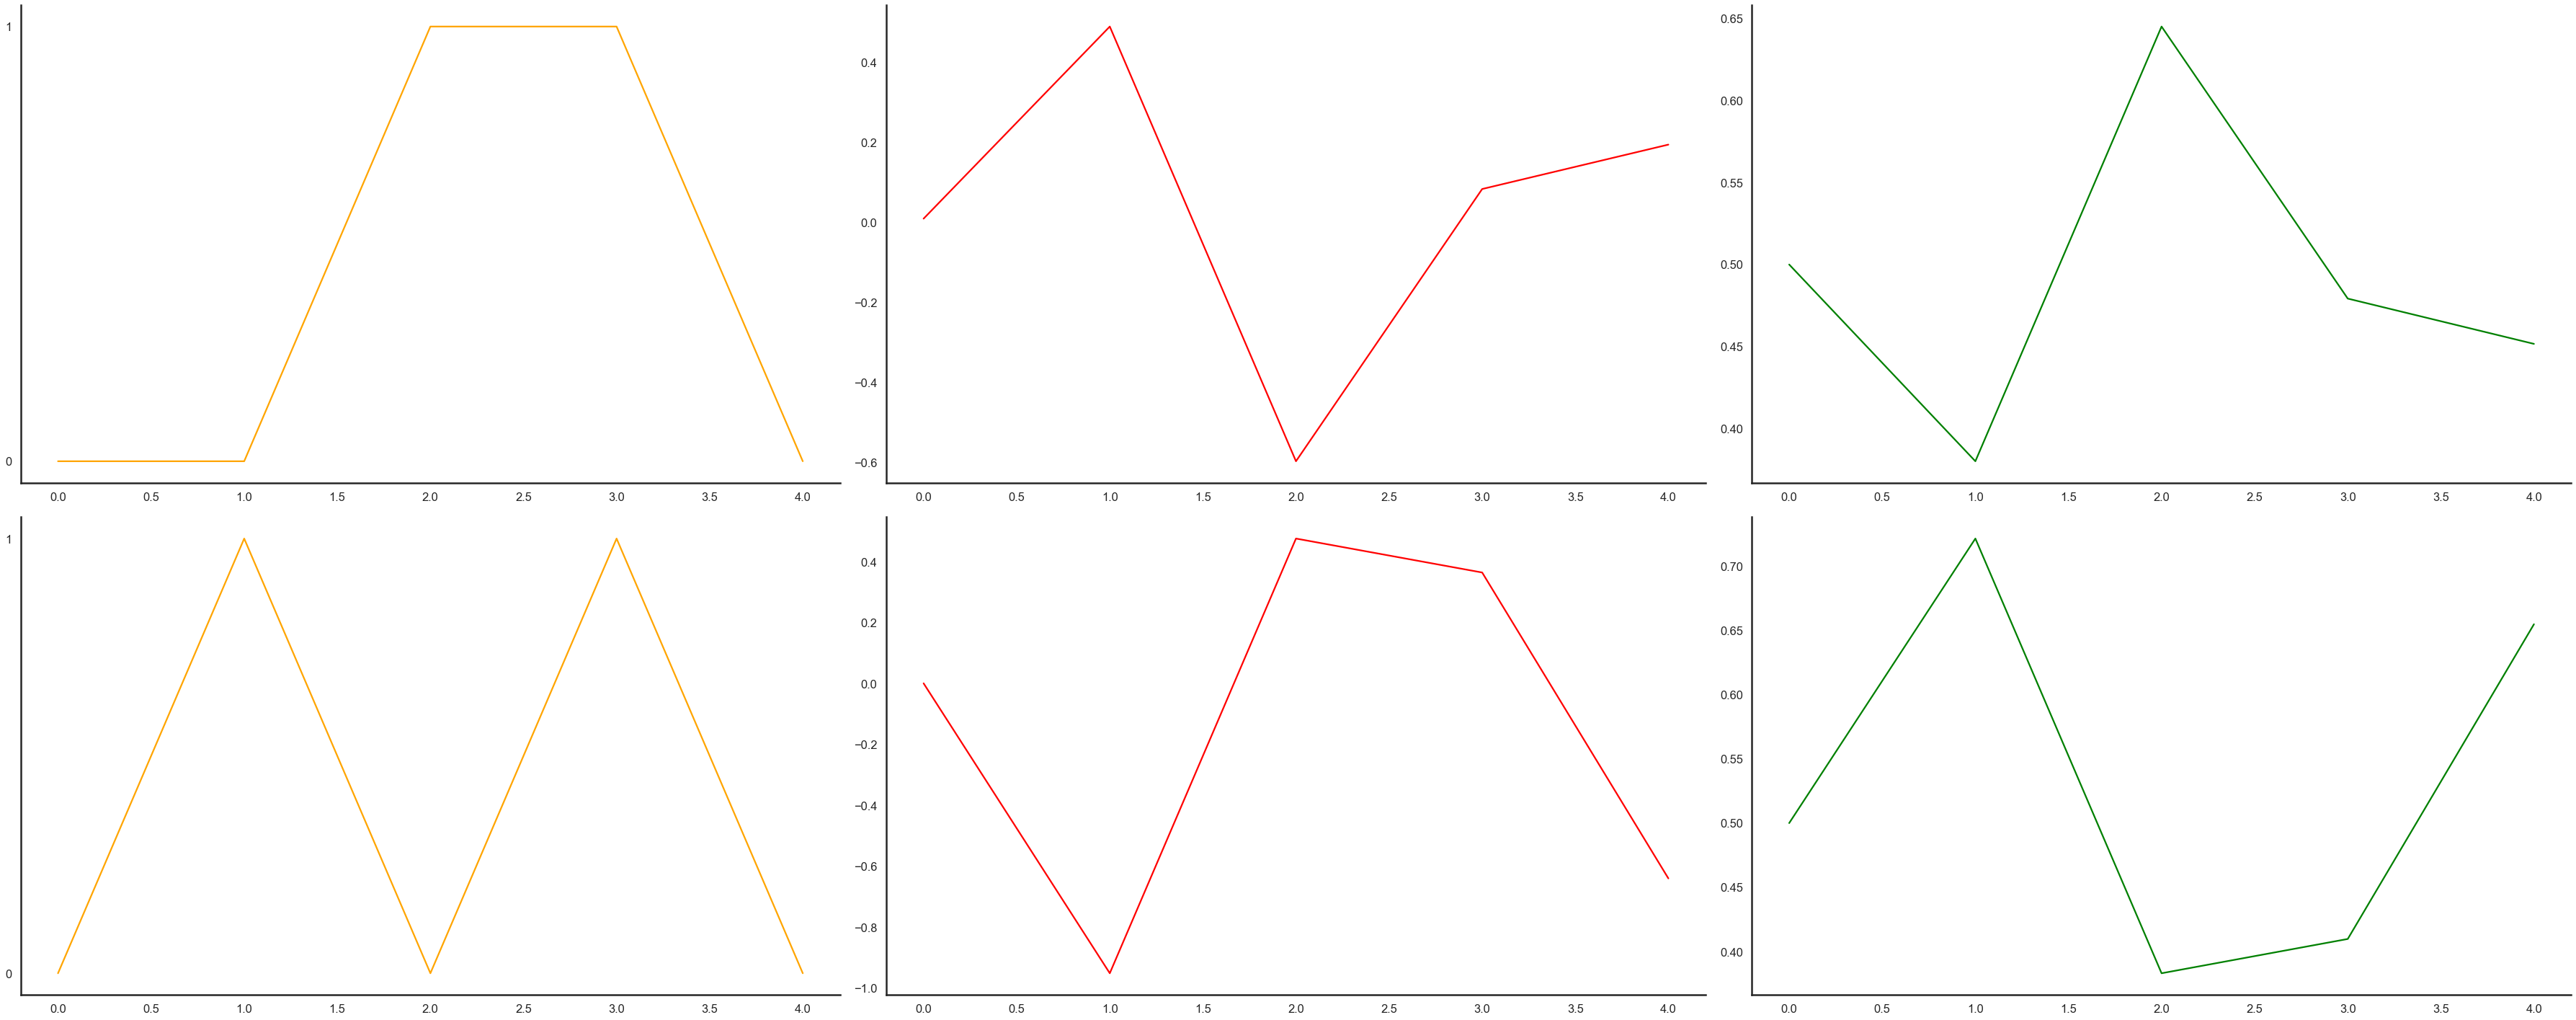

In [75]:
bints.snapshot(N=2,T=5)

In [76]:
bints.optimize(max_iter = 1000,lr=1e-10)

tensor([[ 1.5910e+03,  9.1414e+00,  2.4560e+00,  9.8047e+00],
        [-7.8173e+07, -1.0244e+08, -8.1263e+06, -1.0129e+04]],
       grad_fn=<DiagonalBackward0>)
tensor(inf, grad_fn=<SumBackward0>)
tensor([[ 1.5910e+03,  9.1414e+00,  2.4560e+00,  9.8047e+00],
        [-7.8173e+07, -1.0244e+08, -8.1263e+06, -1.0129e+04]],
       grad_fn=<DiagonalBackward0>)
EM-step ELBO: tensor(-inf, grad_fn=<NegBackward0>)
tensor([[ 1.5910e+03,  9.1414e+00,  2.4560e+00,  9.8047e+00],
        [-7.8173e+07, -1.0244e+08, -8.1263e+06, -1.0129e+04]],
       grad_fn=<DiagonalBackward0>)
tensor(inf, grad_fn=<SumBackward0>)
tensor([[ 1.5910e+03,  9.1414e+00,  2.4560e+00,  9.8047e+00],
        [-7.8173e+07, -1.0244e+08, -8.1263e+06, -1.0129e+04]],
       grad_fn=<DiagonalBackward0>)
tensor([[ 1.5910e+03,  9.1414e+00,  2.4560e+00,  9.8047e+00],
        [-7.8173e+07, -1.0244e+08, -8.1263e+06, -1.0129e+04]],
       grad_fn=<DiagonalBackward0>)
tensor(inf, grad_fn=<SumBackward0>)
tensor([[ 1.5910e+03,  9.1414e+00,  

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[n

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
EM-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
       

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
EM-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
       

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, na

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[n

tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, na

EM-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[n

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
EM-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
       

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[n

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
EM-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
       

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[n

tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
EM-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
t

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[n

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
V-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
EM-step ELBO: tensor(nan, grad_fn=<NegBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor(nan, grad_fn=<SumBackward0>)
tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)
tensor([[nan, nan, nan, nan],
       

tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan]], grad_fn=<DiagonalBackward0>)


KeyboardInterrupt: 

In [71]:
bints.true_sigma
bints.true_sigma_inv

array([[12.97508123, -4.18091467],
       [-4.18091467,  3.53289566]])

In [70]:
bints.sigma

tensor([[nan, nan],
        [nan, nan]], requires_grad=True)

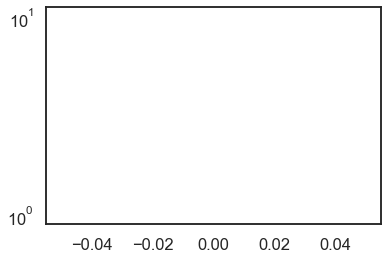

In [23]:
elbo = bints.elbo_track
elbo = elbo.detach().numpy()
f,ax=plt.subplots()
ax.set_yscale('log')
ax.plot(elbo[1:])


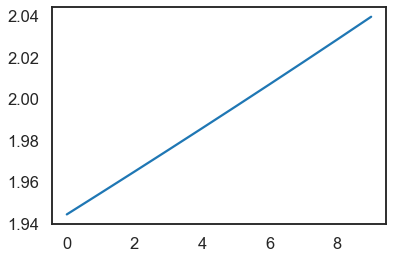

In [26]:
plt.plot(bints.B_error_track[1:])